# Project: Spam/Ham Classification

This project was for my class at UC Berkeley called *Data 100 (Principles and Techniques of Data Science)*. I created a classifier that can **distinguish spam (junk, commercial, or bulk) emails from ham (non-spam) emails** and **competed against other students in a class-wide Kaggle competition to find who could create the best model.**

Main focus and goals of the project include:

- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

In [22]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data
The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. I will predict labels for these emails and submit my predictions to Kaggle for evaluation.

In [23]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()
test

,id,subject,email
0,0,Subject: CERT Advisory CA-2002-21 Vulnerabilit...,\n \n -----begin pgp signed message-----\n \n ...
1,1,Subject: ADV: Affordable Life Insurance ddbfk\n,low-cost term-life insurance!\n save up to 70%...
2,2,Subject: CAREER OPPORTUNITY. WORK FROM HOME\n,------=_nextpart_000_00a0_03e30a1a.b1804b54\n ...
3,3,Subject: Marriage makes both sexes happy\n,"url: http://www.newsisfree.com/click/-3,848315..."
4,4,Subject: Re: [SAtalk] SA very slow (hangs?) on...,on thursday 29 august 2002 16:39 cet mike burg...
...,...,...,...
995,995,Subject: Re: Alsa/Redhat 8 compatability\n,"once upon a time, brian wrote :\n \n > \n > ..."
996,996,Subject: Re: Goodbye Global Warming\n,\n --]> a green once said that if the spotted ...
997,997,Subject: Re: Entrepreneurs\n,"on fri, 23 aug 2002, robert harley wrote:\n \n..."
998,998,Subject: Re: [ILUG] slashdot EW Dijkstra humor\n,jpl suggested:\n > recursion is only truely u...


### Cleaning the data
First, I check if the data contains any missing values. If there are NaN values in the 'subject' or 'email' columns, I replace them with empty strings. 

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

In [24]:
numberNaN = original_training_data.isnull().sum()
numberNaN

original_training_data['subject'].fillna('', inplace = True)
original_training_data

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0
...,...,...,...,...
8343,8343,Subject: Re: ALSA (almost) made easy\n,"thanks for this, i'm going to give them anothe...",0
8344,8344,Subject: Re: Goodbye Global Warming\n,thanks for the link - i'm fascinated by archae...,0
8345,8345,Subject: hello\n,we need help. we are a 14 year old fortune 50...,1
8346,8346,Subject: Your application is below. Expires Ju...,<html>\n \n \n <head> \n <meta charset=3dutf-8...,1


### Initial hypothesis
Here are the text of the first ham and the first spam email in the original training set.

In [25]:
ham = original_training_data.loc[original_training_data['spam'] == 0]
spam = original_training_data.loc[original_training_data['spam'] == 1]
first_ham = ham['email'].iloc[0]
first_spam = spam['email'].iloc[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



The spam email is formatted with html while the ham email is not - this difference between the two emails might be related to the identification of spam.

### Training Validation Split
The training data is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  This **validation data** is needed to assess the performance of the classifier after training. 

Note that the class set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. The tests depend on this random seed.

In [26]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

## Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails.

In [27]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = 1 * np.array([texts.str.contains(word) for word in words]).T
    return indicator_array

## Basic Exploratory Date Analysis

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.

The following bar chart (which was created using `sns.barplot`) compares the proportion of spam and ham emails containing certain words.

Text(0.5, 1.0, 'Frequency of Words in Spam/Ham Emails')

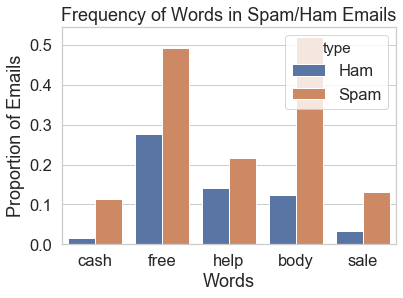

In [28]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
emails = train.iloc[:, 2]

wit = words_in_texts(['cash', 'free', 'help', 'body', 'sale'], emails)
dfwit = pd.DataFrame(wit, columns = ['cash', 'free', 'help', 'body', 'sale'])
dfwit['type'] = pd.Series(train.iloc[:,3].replace(0, 'Ham').replace(1, 'Spam'))
dfwitm = dfwit.melt('type').rename(columns={"variable": 'Words', "value": "Proportion of Emails"})

sns.barplot('Words', 'Proportion of Emails', hue = 'type', data = dfwitm, ci = None).set_title('Frequency of Words in Spam/Ham Emails')

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

The following class conditional density plot (which was created using `sns.distplot`) compares he distribution of the length of spam emails to the distribution of the length of ham emails in the training set.

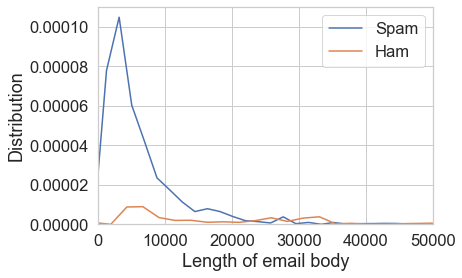

In [18]:
dfle = pd.DataFrame(train)
dfle['Length of email body'] = train['email'].str.len()
dfle = dfle.drop(['id', 'subject', 'email'], axis = 1).replace(0, 'Ham').replace(1, 'Spam')
dfles = dfle[dfle['spam'] == 'Spam']
dfleh = dfle[dfle['spam'] == 'Ham']
sns.distplot(dfles['Length of email body'], hist = False, label = "Spam").set(xlim = (0, 50000), ylabel = 'Distribution')
sns.distplot(dfleh['Length of email body'], hist = False, label = 'Ham').set(xlim = (0, 50000), ylabel = 'Distribution')
plt.legend()


## Basic Classification

The output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

Given 5 words that might be useful as features to distinguish spam/ham emails, use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

In [19]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']
emails = pd.Series(train['email'])

X_train = words_in_texts(some_words, emails)
Y_train = train['spam']

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

Now that we have matrices, we can use to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the accuracy of the model (on the training data) in the cell below. 

In [20]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = (model.predict(X_train) == Y_train).mean()
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


C:\Users\cheah\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Evaluating Classifiers
That doesn't seem too shabby! But the classifier above isn't as good as this might lead us to believe. First, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The following image might help:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

Here are the **precision**, **recall**, and **false-alarm rate** of the `LogisticRegression` classifier created and trained earlier.

In [21]:
Y_pred = model.predict(X_train)
tp = (Y_train & Y_pred)
tn = np.logical_and(Y_pred == 0, Y_train == 0)
fp = (~Y_train & Y_pred)
fn = (Y_train & ~Y_pred)
logistic_predictor_precision = tp.sum() / (tp.sum() + fp.sum())
display(logistic_predictor_precision)
logistic_predictor_recall = tp.sum() / (tp.sum() + fn.sum())
display(logistic_predictor_recall)
logistic_predictor_far = fp.sum() / (fp.sum() + tn.sum())
display(logistic_predictor_far)

0.6422287390029325

0.11418143899895725

0.021805183199285077

We can see that there more **false negatives** when using the logistic regression classifier.

Given the word features above, one reason this classifier is performing poorly could be that the words may not have had a large ham to spam proportion difference to be able to be classified by logistic regression.

## Improving the Model
With this in mind, it is now my task to make the spam filter more accurate.

Here are some ideas given by the class for improving the model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

We may use whatever method to create features, but we are not allowed to import any external feature extraction libraries. In addition, we are only allowed to train logistic regression models. No random forests, k-nearest-neighbors, neural nets, etc.

In [32]:
import re
from collections import Counter
!pip install WordCloud
from wordcloud import WordCloud
from wordcloud import STOPWORDS

### Process
Before doing anything, I cleaned up my data by replacing NaN values, making everything lowercase, removing line breaks and multiple spaces, and removing stopwords. Then using .Counter() from collections, I created 2 dataframes (one for spam and one for ham) that showed the most common words found in each type of email as well as the overall proportion of each word. I manually tried out different amounts of words that had a high spam to ham proportion difference. 

While cleaning up my data I initially remove punctuation and words that were  <html> tags, but doing so resulted in a <88% accuracy. Knowing that <html> tags were often used in spam emails, I kept the punctuation and <html> tags and my accuracy jumped higher. 
    
For good features, I was expecting to only have whole words such as 'offer' and 'free,' but was surprised to see a lot of word fragments and characters like '>' and 'td' (most likely due to the high amount of <html> tags in spam emails). On the other hand, I was surprised that characters such as '!' and '%' didn't improve the accuracy as much.

In [33]:
stopwords = set(STOPWORDS)

#Cleans emails
def preprocess(email):
    email2 = email.copy()
    email2 = email2.fillna(" ") #replaces NaN
    email2 = email2.str.lower() #makes everything lowercase
    #email2 = email2.str.replace(r'\<[^()]*\>', '') #removes <> tags
    #email2 = email2.str.replace(r'[^\w\d\s]', ' ') #removes punctuation
    email2 = email2.str.replace(r'\s+', ' ') #removes multiple spaces and line breaks
    email2 = email2.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) #removes stopwords
    return email2

In [42]:
#Dictionary of most common spam words and the proportion of the words in emails
spamlist = []
for x in train[train['spam'] == 1]['email']:
    for y in x.split():
        spamlist.append(y)
spamdf = pd.DataFrame.from_dict(Counter(spamlist), orient = 'index').sort_values(by = 0, ascending= False).reset_index()
spamdf.columns = ['spam word', 'spam count']
spamdf['spam proportion'] = spamdf['spam count'] / spamdf['spam count'].sum()
display(spamdf.head(20))

#Dictionary of most common ham words and the proportion of the words in emails
hamlist = []
for x in train[train['spam'] == 0]['email']:
    for y in x.split():
        hamlist.append(y)
hamdf = pd.DataFrame.from_dict(Counter(hamlist),orient = 'index').sort_values(by = 0, ascending = False).reset_index()
hamdf.columns = ['ham word', 'ham count']
hamdf['ham proportion'] = hamdf['ham count'] / hamdf['ham count'].sum()
display(hamdf.head(20))

,spam word,spam count,spam proportion
0,=,9228,0.014398
1,<td,7805,0.012178
2,</tr>,4631,0.007226
3,<tr>,3627,0.005659
4,<font,3478,0.005427
5,will,3351,0.005228
6,<br>,3344,0.005217
7,"helvetica,",3054,0.004765
8,-,2912,0.004543
9,</td>,2675,0.004174


,ham word,ham count,ham proportion
0,>,47992,0.037288
1,<td,10702,0.008315
2,<a,7088,0.005507
3,-,5489,0.004265
4,=,5469,0.004249
5,-->,4416,0.003431
6,<!--,4079,0.003169
7,<table,4070,0.003162
8,will,3934,0.003057
9,"width=""1""",3917,0.003043


In [43]:
some_words2 = ['html', 'href', 'offer', 'url', 'click', '>', '=', '.org', 'free', '<body>', 'td']

In [44]:
def process(data):
    
    data['email'] = preprocess(data['email']) #Cleans up emails
    data['subject'].fillna('', inplace = True)
    
    words = words_in_texts(some_words2, data['email'])
    
    df = pd.DataFrame()
    df = pd.concat([df, pd.DataFrame(words)], axis=1)
    df = pd.concat([df, pd.DataFrame([len(x.split()) for x in data['subject']], columns=['Subject Count'])], axis=1)
    df = pd.concat([df, pd.DataFrame([len(x.split()) for x in data['email']], columns=['Body Count'])], axis=1)
    df = pd.concat([df, pd.DataFrame([len(x) for x in data['subject']], columns=['Subject Length'])], axis=1)
    df = pd.concat([df, pd.DataFrame([len(x) for x in data['email']], columns=['Body Length'])], axis=1)
    return df.fillna(0)


In [45]:
X_train2 = process(train)
Y_train2 = train['spam']

model2 = LogisticRegression(fit_intercept = True)
model2 = model2.fit(X_train2, Y_train2)

trainacc = (model2.predict(X_train2) == Y_train2).mean()
trainacc

C:\Users\cheah\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9036337015839212

In [46]:
X_val = process(val)
Y_val = val['spam']

testacc = (model2.predict(X_val) == Y_val).mean()
testacc

C:\Users\cheah\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cheah\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


0.8946107784431138

### Visualizations
I plotted 2 wordclouds to visibly see the most commmon words found in spam and ham in my uncleaned emails. I wanted to be able to see the word differences/similarities between the two groups and manually pick out some words to see how they affected my accuracy. 

The larger (and therefore more frequent) words are 'font' and 'face' for spam emails and 'img' and 'src' for ham emails. Both shared roughly the same size/frequency of words like 'width' and 'height'.

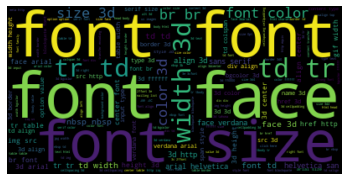

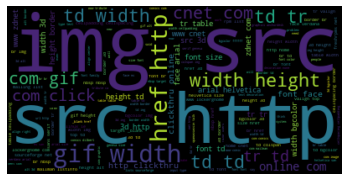

In [47]:
#Wordcloud of spam emails
spamemails = ' '.join(list(train[train['spam'] == 1]['email']))
wordcloud = WordCloud(max_font_size = 100).generate(spamemails)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#Wordcloud of ham emails
hamemails = ' '.join(list(train[train['spam'] == 0]['email']))
wordcloud = WordCloud().generate(hamemails)
wordcloud = WordCloud(max_font_size = 100).generate(hamemails)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### ROC Curve
In most cases we won't be able to get no false positives and no false negatives, so we have to compromise. 

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot an ROC curve for your final classifier (the one you use to make predictions for Kaggle).

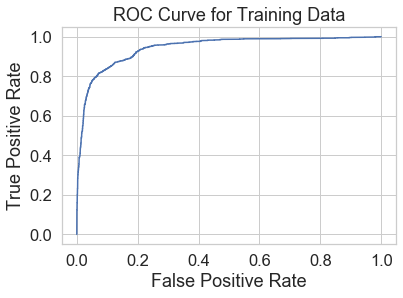

In [49]:
from sklearn.metrics import roc_curve

Y_pred_prob = model2.predict_proba(process(train))
fpr, tpr, _ = roc_curve(Y_train, Y_pred_prob[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data');

## Submitting to Kaggle
You can find the Kaggle page here: https://www.kaggle.com/c/ds100fa19

I placed 474 out of 967 (top 50%) with a test accuracy of 0.90857 (not too bad for my first try).
